In [1]:
from torch.utils.data import Dataset
import os
import glob
import classic_algos.bicubic_interpolation as bicubic
import classic_algos.lanczos as lanczos
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import random
from pathlib import Path
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [2]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))

BATCH_SIZE = 16
EPOCHS = 200

DATA_DIR = Path.home() / '.data'
TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
class SatelliteSRDataset(Dataset):
    def __init__(self, root_dir, hr_patch_size=144, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.hr_patch_size = hr_patch_size
        self.augment = augment
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # C x H x W

        image_norm = image.astype(np.float32) / 255.0

        #random crop
        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top+self.hr_patch_size, left:left+self.hr_patch_size]
        if self.augment:
            # Flip Horizontal
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=2)

            # Flip Vertical
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=1)

            # rotations
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np.astype(np.float32))  # C x H x W, [0,1]
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        # LR from augmented HR patch
        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))  # H x W x C, [0,1]
        lr_size = self.hr_patch_size // 2
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)
        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))  # C x h_lr x w_lr
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = self.conv2(self.relu(self.conv1(x)))
        return x + residual

class ResSR(nn.Module):
    def __init__(self, num_channels=3, num_res_blocks=8, n_feats=64):
        super(ResSR, self).__init__()

        self.head = nn.Conv2d(num_channels, n_feats, kernel_size=3, padding=1)

        self.body = nn.Sequential(*[
            ResidualBlock(n_feats) for _ in range(num_res_blocks)
        ])

        self.body_end = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

        self.upsample = nn.Sequential(
            nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )

        self.tail = nn.Conv2d(n_feats, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x_head = self.head(x)

        res = self.body(x_head)
        res = self.body_end(res)
        res += x_head

        x_up = self.upsample(res)
        out = self.tail(x_up)

        return torch.clamp(out, 0.0, 1.0)


In [4]:
train_dataset = SatelliteSRDataset(TRAIN_DIR, hr_patch_size=144, augment=True)
val_dataset = SatelliteSRDataset(VAL_DIR, hr_patch_size=144, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = ResSR().to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [ ]:
loss = []
psnr_metric = []
best_psnr = 0
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch}"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        batch_loss = criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss.append(avg_loss)

    model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)

            loss = criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()
            val_psnr += PSNR(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_psnr = val_psnr / len(val_loader)

    psnr_metric.append(avg_val_psnr)
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Val PSNR: {avg_val_psnr:.2f} dB")

    scheduler.step(avg_val_loss)

    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(model.state_dict(), DATA_DIR / 'rgb_ressr_best_model.pth')
        print(f"  [!] New Best PSNR: {best_psnr:.2f} dB saved.")

    if epoch % 20 == 0:
         torch.save(model.state_dict(), MODEL_DIR / f'rgb_ressr_checkpoint_{epoch}.pth')

print("training complete.")


In [ ]:
plt.figure()
plt.suptitle("Результаты")

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(psnr_metric, label='Val PSNR')
plt.title('PSNR')
plt.xlabel('Epochs (x5)')
plt.ylabel('dB')
plt.legend()
plt.grid(True)

plt.show()

File: /home/aaa/.data/UCMerced_LandUse_Split/val/storagetanks/storagetanks88.tif


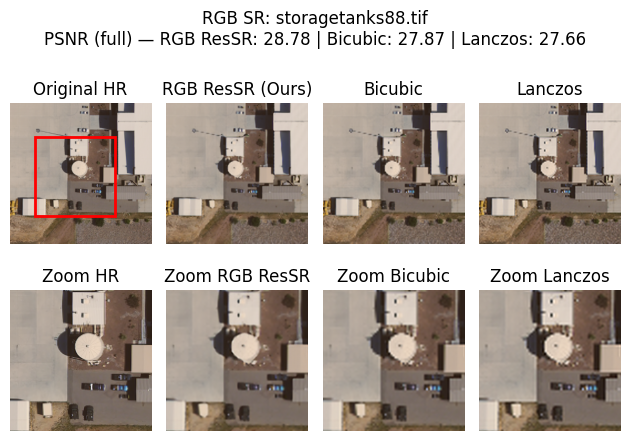

Zoom Area: Top=61, Left=45, Size=144


In [12]:
ZOOM_PATCH_SIZE = 144
SCALE_Y = 2
MODEL_ARCH = ResSR
MODEL_PATH = Path.home() / '.data' / 'rgb_ressr_best_model.pth'
RANDOM_CROP = True

full_idx = random.randint(0, len(val_dataset.file_paths) - 1)
img_path = val_dataset.file_paths[full_idx]
print(f"File: {img_path}")

with rasterio.open(img_path) as src:
    image_rgb = src.read() # (C, H, W)

image_rgb = image_rgb.astype(np.float32) / 255.0


C, H, W = image_rgb.shape

lr_h = H // SCALE_Y
lr_w = W // SCALE_Y

image_rgb_hwc = np.transpose(image_rgb, (1, 2, 0)) # (H, W, C)

lr_rgb_hwc = bicubic.SR_bicubic(image_rgb_hwc, lr_w, lr_h,
                                preserve_range=True, output_dtype=np.float32)

lr_rgb_chw = np.transpose(lr_rgb_hwc, (2, 0, 1))
lr_tensor = torch.from_numpy(lr_rgb_chw).unsqueeze(0).float().to(device) # (1, C, H, W)

model_vis = MODEL_ARCH().to(device)

try:
    weights = torch.load(MODEL_PATH, map_location=device)
    model_vis.load_state_dict(weights)
    model_vis.eval()
except Exception as e:
    print(f"ERROR loading model: {e}")

with torch.no_grad():
    sr_model_tensor = model_vis(lr_tensor) # (1, C, H, W)

sr_bicubic_hwc = bicubic.SR_bicubic(lr_rgb_hwc, H, W,
                                    preserve_range=True, output_dtype=np.float32)
sr_lanczos_hwc = lanczos.SR_lanczos(lr_rgb_hwc, H, W,
                                    preserve_range=True, output_dtype=np.float32)

sr_bicubic_tensor = torch.from_numpy(np.transpose(sr_bicubic_hwc, (2, 0, 1))).unsqueeze(0).to(device) # (H, W, C) -> (1, C, H, W)
sr_lanczos_tensor = torch.from_numpy(np.transpose(sr_lanczos_hwc, (2, 0, 1))).unsqueeze(0).to(device)
hr_tensor = torch.from_numpy(image_rgb).unsqueeze(0).to(device)

psnr_model = PSNR(sr_model_tensor, hr_tensor).item()
psnr_bicubic = PSNR(sr_bicubic_tensor, hr_tensor).item()
psnr_lanczos = PSNR(sr_lanczos_tensor, hr_tensor).item()

if RANDOM_CROP:
    top = random.randint(0, H - ZOOM_PATCH_SIZE)
    left = random.randint(0, W - ZOOM_PATCH_SIZE)
else:
    top = max((H - ZOOM_PATCH_SIZE) // 2, 0)
    left = max((W - ZOOM_PATCH_SIZE) // 2, 0)

def get_crops(tensor_img):
    full = tensor_img.squeeze().detach().cpu().numpy() # (1, C, H, W) -> (C, H, W)
    full = np.transpose(full, (1, 2, 0)) # (H, W, C)
    crop = full[top:top+ZOOM_PATCH_SIZE, left:left+ZOOM_PATCH_SIZE, :]
    return full, crop

hr_full, hr_crop = get_crops(hr_tensor)
sr_full, sr_crop = get_crops(sr_model_tensor)
bi_full, bi_crop = get_crops(sr_bicubic_tensor)
la_full, la_crop = get_crops(sr_lanczos_tensor)

fig, axes = plt.subplots(2, 4)
model_name = "RGB ResSR"

fig.suptitle(f'RGB SR: {Path(img_path).name}\nPSNR (full) — {model_name}: {psnr_model:.2f} | Bicubic: {psnr_bicubic:.2f} | Lanczos: {psnr_lanczos:.2f}')

imgs_full = [hr_full, sr_full, bi_full, la_full]
titles = ['Original HR', f'{model_name} (Ours)', 'Bicubic', 'Lanczos']

for ax, img, title in zip(axes[0], imgs_full, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
    ax.set_title(title)

imgs_crop = [hr_crop, sr_crop, bi_crop, la_crop]
titles_zoom = ['Zoom HR', f'Zoom {model_name}', 'Zoom Bicubic', 'Zoom Lanczos']

for ax, img, title in zip(axes[1], imgs_crop, titles_zoom):
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
    ax.set_title(title)

rect = plt.Rectangle((left, top), ZOOM_PATCH_SIZE, ZOOM_PATCH_SIZE, linewidth=2, edgecolor='r', facecolor='none')
axes[0, 0].add_patch(rect)

plt.tight_layout()
plt.show()

print(f"Zoom Area: Top={top}, Left={left}, Size={ZOOM_PATCH_SIZE}")